# Attention intuition

The lecture notes on Deep Learning from [Francois Fleuret](https://fleuret.org/dlc/materials/dlc-handout-13-2-attention-mechanisms.pdf) contain a very nice intuition on why and where the attention mechanism works better than conv nets.

In the example, he considers a toy sequence-to-sequence problem with triangular and rectangular shapes with random heights as input.
The expected target contains the same shapes but with their heights averaged, as in the figure below.


![](images/data_example.png)

Since there was no source code available in his lecture (as far as I know), I have tried to reproduce the same intuition in this notebook.
As we can see, with the exact training procedure, the attention mechanism is able to learn the task much faster than the conv net.
The conv net model's poor performance is expected due to its inability to look far away the input signal to learn the task.
There are plenty of mechanisms we can equip the conv net with to make it work better (more layers, fully connected layers, ...), but the attention mechanism is a very simple and elegant solution to this problem.



## Dataset

Follow below one example of the dataset with the input and its corresponding target

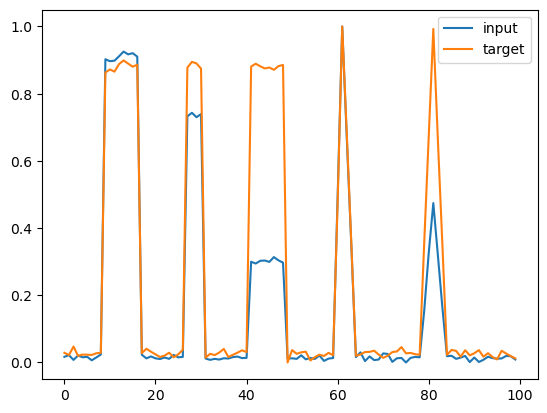

In [6]:
import numpy as np
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

np.random.seed(10)


def norm_0_1(X):
    return (X - X.min()) / (X.max() - X.min())


@dataclass
class ShapeLog:
    """
    A class to store the information about the shapes in the image
    """

    shape_type: str
    base_point: int
    width: int
    height: int


def generate_pair(size: int = 100, max_height: int = 50, noise_std: float = 0.3):
    """
    Generate a pair of images. One with the randomly generated sequence of triangles and/or rectangles
    and the other one with the average hights of the shapes in the first image.

    Args:
        size: The size of the image on the x axis
        max_hight: The maximum hight of the shapes

    Returns:
        A tuple of two images. The first one is the image with the shapes and the second one is the image with the average hight of the shapes
    """

    min_height = 5
    base_size_range = [3, 10]
    offset = 0
    min_step = 10

    shape_choices = ["triangle", "rectangle"]
    # shape_choices = ["triangle"]

    shape_logs = []

    input = np.zeros(size)

    def draw(input, shape_type, base_point, width, height):
        if shape_type == "triangle":
            pick_point = (base_point + (base_point + width)) // 2
            input[pick_point] = height

            # Computing the triangle's first ramp
            num_points = pick_point - base_point
            values = np.linspace(0, height, num=num_points, endpoint=False, dtype=int)
            input[base_point : (base_point + width // 2)] = values

            # Computing the triangle's second ramp
            num_points = (base_point + width) - pick_point
            values = np.linspace(height, 0, num=num_points, endpoint=False, dtype=int)
            input[(base_point + width // 2) : base_point + width] = values

        else:
            # Rectangle
            input[base_point : (base_point + width)] = height

        return input

    def average_shapelogs_per_type(shape_logs):
        averages = {}
        for shape in shape_choices:
            averages[shape] = np.mean([s.height for s in shape_logs if s.shape_type == shape])

        input_averages = np.zeros(size)
        for s in shape_logs:
            input_averages = draw(input_averages, s.shape_type, s.base_point, s.width, averages[s.shape_type])

        return input_averages

    while offset < size:
        # Picking a point based on the current offset and the max displacement allowed
        base_point = np.random.randint(offset, offset + base_size_range[1])

        # Picking the width of the shape
        width = np.random.randint(base_size_range[0], base_size_range[1])

        if base_point + width > size:
            break

        # Picking the height of the shape
        height = np.random.randint(min_height, max_height)

        # Picking the shape type
        shape_type = np.random.choice(shape_choices)

        shape_logs.append(ShapeLog(shape_type, base_point, width, height))

        input = draw(input, shape_type, base_point, width, height)

        offset = base_point + width + min_step

    input += np.random.normal(0, noise_std, size)

    target = average_shapelogs_per_type(shape_logs) + np.random.normal(0, noise_std, size)

    return norm_0_1(np.expand_dims(input, axis=0).astype(np.float32)), norm_0_1(
        np.expand_dims(target, axis=0).astype(np.float32)
    )


class ShapeDataset(Dataset):
    def __init__(self, max_samples=1000, size=100, max_height=50, noise_std=0.3):
        """
        Shape dataset.
        It generates a pair of images. One with the randomly generated sequence of triangles and/or rectangles
        and the other one with the average hights of the shapes in the first image.

        Args:
            max_samples: The number of samples to generate
            size: The size of the image on the x axis
            max_hight: The maximum hight of the shapes
            noise_std: The standard deviation of the noise to add to the images

        """
        self.images = [generate_pair() for _ in range(max_samples)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx][0], self.images[idx][1]


original, target = generate_pair()
# Plotting the dataset
fig = plt.figure()

plt.plot(range(len(original[0])), original[0], label="input")
plt.plot(range(len(target[0])), target[0], label="target")
plt.legend()    

## Training the models

In [ ]:
# Implementation of the self attention layer
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, key_dim):
        super().__init__()
        self.conv_Q = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        self.conv_K = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        self.conv_V = nn.Conv1d(in_dim, out_dim, kernel_size=1, bias=False)

    def forward(self, x):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        A = Q.transpose(1, 2).matmul(K).softmax(2)
        y = A.matmul(V.transpose(1, 2)).transpose(1, 2)
        return y
    
def train_model(model, epochs=20, device="cuda"):
    train_loader = torch.utils.data.DataLoader(
        dataset=ShapeDataset(size=100, max_height=50, noise_std=0.3, max_samples=10000),
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

    model.train()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    loss_per_epoch = []    
    for epoch in range(epochs):
        for i, (input, target) in enumerate(train_loader):
            input = input.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        if epoch%10==0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")
        loss_per_epoch.append(loss.item())

    return loss_per_epoch


# Training the regular model with no self attention
print("Training with conv model")
conv_model = nn.Sequential(
    nn.Conv1d(1, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 1, kernel_size=(5,), padding="same"),
)
loss_per_epoch_conv = train_model(conv_model, epochs=50)

# Training with self attention
print("Training with attention model")
attention_model = nn.Sequential(
    nn.Conv1d(1, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    SelfAttentionLayer(in_dim=64, out_dim=64, key_dim=64),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 1, kernel_size=(5,), padding="same"),
)
loss_per_epoch_attention = train_model(attention_model, epochs=50)

plt.figure()
plt.plot(loss_per_epoch_conv, label="Without Attention")
plt.plot(loss_per_epoch_attention, label="With Attention")
plt.legend()

Training with conv model
Epoch: 0, Loss: 0.007099784445017576
Epoch: 10, Loss: 0.006277458742260933
Epoch: 20, Loss: 0.005937633570283651
Epoch: 30, Loss: 0.004296785686165094
Epoch: 40, Loss: 0.005580654833465815
Training with attention model
Epoch: 0, Loss: 0.006035702768713236
Epoch: 10, Loss: 0.0045489040203392506
Epoch: 20, Loss: 0.0013205171562731266
Epoch: 30, Loss: 0.0006364810978993773
